In [ ]:
!git lfs pull

In [1]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt

## Gaussian Mixture Simulation

In [2]:
### Simulating data, fitting SVM, calculating accuracy

class InfeasibleError(Exception):
   """ Infeasible Problem """
   pass

def sim_data(n, d, pi, mu, sig1=1, sig0=1):
    """ Generate Gaussian Mixture Data """
    n1 = int(np.ceil(n * pi))
    n0 = n - n1
    mu1 = np.append(mu, np.zeros(d-1))
    mu0 = -mu1
    Sig1 = sig1*np.identity(d)
    Sig0 = sig0*np.identity(d)
    X1 = np.random.multivariate_normal(mean=mu1, cov=Sig1, size=n1)
    X0 = np.random.multivariate_normal(mean=mu0, cov=Sig0, size=n0)
    X = np.vstack([X1, X0])
    y = np.repeat([1, 0], [n1, n0])
    return [X, y]

def SVM(X, y, C=1, shrinking=True, tol=1e-8, class_weight=None, standard=True):
    clf = SVC(C=C, kernel='linear', shrinking=shrinking, tol=tol, class_weight=class_weight)
    clf.fit(X, y)
    beta = clf.coef_[0]
    beta0 = clf.intercept_[0]
    kappa = 1
    if standard:
        beta_norm = np.linalg.norm(beta)
        beta, beta0, kappa = beta/beta_norm, beta0/beta_norm, kappa/beta_norm
    return [clf, beta, beta0, kappa]

def sigmoid(x):
    if isinstance(x, np.ndarray):
        for i, z in enumerate(x):
            if z > 0:
                x[i] = 1/(1 + np.exp(-z))
            else:
                x[i] = np.exp(z)/(1 + np.exp(z))
        return x
    else:
        if x > 0:
            return 1/(1 + np.exp(-x))
        else:
            return np.exp(x)/(1 + np.exp(x))

def get_model(pi, n, d, mu, terminate=False):
    X_train, y_train = sim_data(n=n, d=d, pi=pi, mu=mu)
    md, beta, beta0, kappa = SVM(X_train, y_train, C=1)
    # Check linear separability
    if np.mean(md.predict(X_train) == y_train) < 1:
        if terminate:
            raise InfeasibleError(f'Training data is not separable for pi = {pi:.3f}.')
        else:
            print(f'Training data is not separable for pi = {pi:.3f}.')
    # two support vectors in each class
    idx_SV = np.array([np.where(y_train[md.support_] == 1)[0][0],
                       np.where(y_train[md.support_] == 0)[0][0]])
    SV2 = md.support_vectors_[idx_SV, :]
    return [md, beta, beta0, kappa, SV2]

### Single plot

In [3]:
def reliability_diagram(pi, predictions, true_labels, save, save_dir, legend, num_bins=10, fig_size=(3, 3)):
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    accuracies = np.zeros(num_bins)
    confidences = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = (predictions > bin_edges[i]) & (predictions <= bin_edges[i + 1])
        bin_count = np.sum(in_bin)
        if bin_count > 0:
            accuracies[i] = np.mean(true_labels[in_bin] == 1)
            confidences[i] = np.mean(predictions[in_bin])
            bin_sizes[i] = bin_count
    total_samples = len(predictions)
    ece = np.sum((accuracies - confidences)**2 * np.array(bin_sizes) / total_samples)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    with plt.style.context('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle'):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fig_size, dpi=100, constrained_layout=True)
        ax.bar(bin_centers, accuracies, width=1/num_bins, color='#5A5B9F', alpha=0.9,
               edgecolor='black', label='Outputs')
        ax.bar(bin_centers, confidences - accuracies, width=1/num_bins, color=(1, 1, 0, 0.1),
               label='Gap', edgecolor=(1, 0, 0, 0.5), bottom=accuracies)
        ax.plot([0, 1], [0, 1], '--', color='gray')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Confidence', fontsize=16)
        ax.set_ylabel('Accuracy', fontsize=16)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_title(rf'$\pi = {pi}$', fontsize=18)
        if legend:
            ax.legend(fontsize=14)
        ax.text(0.95, 0.05, rf"$\widehat{{\mathrm{{CalErr}}}}={ece:.3g}$", ha="right", va="bottom", fontsize=14,
                color="black", bbox=dict(facecolor="lightblue", alpha=0.5, boxstyle="round,pad=0.3"))
        ax.set_aspect('equal')
    if save:
        plt.savefig(save_dir + '.pdf')
    else:
        plt.show()
    return None

def get_reliability_plot(pi, n, d, mu, n_test=10000, seed=2024, fig_size=(3.2, 3.2), legend=False,
                         save=False, save_dir = ''):
    np.random.seed(seed)
    X_test, y_test = sim_data(n=n_test, d=d, pi=pi, mu=mu)
    md, beta, beta0, kappa, SV2 = get_model(pi=pi, n=n, d=d, mu=mu, terminate=True)
    reliability_diagram(pi=pi, predictions=sigmoid(X_test @ beta), true_labels=y_test, fig_size=fig_size,
                        legend=legend, save=save, save_dir = save_dir + f'pi={pi}, mu={mu}, n={n}, d={d}')
    return None

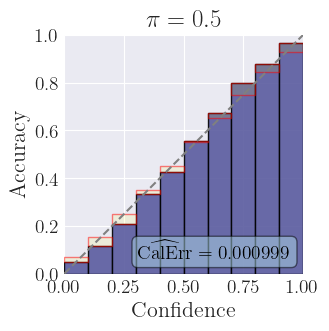

In [4]:
get_reliability_plot(pi=0.5, n=1000, d=500, mu=1)

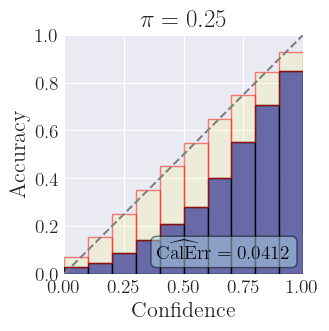

In [5]:
get_reliability_plot(pi=0.25, n=1000, d=500, mu=1)

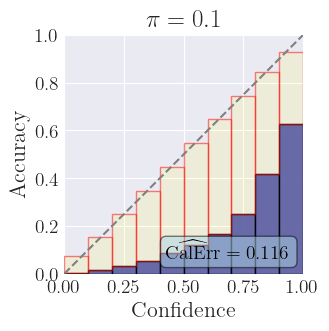

In [6]:
get_reliability_plot(pi=0.1, n=1000, d=500, mu=1)

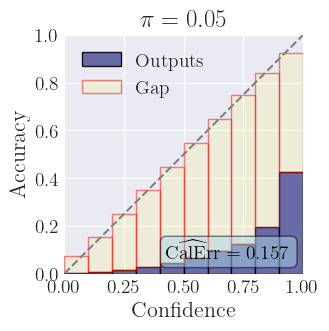

In [7]:
get_reliability_plot(pi=0.05, n=1000, d=500, mu=1, legend=True)

### Multiple plots

In [8]:
# from matplotlib.ticker import MaxNLocator

def get_calibration_stat(predictions, true_labels, num_bins=10):
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    accuracies = np.zeros(num_bins)
    confidences = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = (predictions > bin_edges[i]) & (predictions <= bin_edges[i + 1])
        bin_count = np.sum(in_bin)
        if bin_count > 0:
            accuracies[i] = np.mean(true_labels[in_bin] == 1)
            confidences[i] = np.mean(predictions[in_bin])
            bin_sizes[i] = bin_count
    total_samples = len(predictions)
    ece = np.sum((accuracies - confidences)**2 * np.array(bin_sizes) / total_samples)
    return [accuracies, confidences, bin_centers, ece]

def reliability_plots_sim(pi_list, n, d, mu, n_test=10000, seed=2024, fig_size=(12.6, 3.3), num_bins=10,
                          save=False, save_dir = 'Calibration_'):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    with plt.style.context('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle'):
        fig, ax = plt.subplots(nrows=1, ncols=len(pi_list), figsize=fig_size, dpi=100, constrained_layout=True)
        np.random.seed(seed)
        for i, pi in enumerate(pi_list):
            X_test, y_test = sim_data(n=n_test, d=d, pi=pi, mu=mu)
            md, beta, beta0, kappa, SV2 = get_model(pi=pi, n=n, d=d, mu=mu, terminate=True)
            accuracies, confidences, bin_centers, ece = get_calibration_stat(predictions=sigmoid(X_test @ beta),
                                                                             true_labels=y_test)
            ax[i].bar(bin_centers, accuracies, width=1/num_bins, color='#5A5B9F', alpha=0.9,
               edgecolor='black', label='Outputs')
            ax[i].bar(bin_centers, confidences - accuracies, width=1/num_bins, color=(1, 1, 0, 0.1),
                   label='Gap', edgecolor=(1, 0, 0, 0.5), bottom=accuracies)
            ax[i].plot([0, 1], [0, 1], '--', color='red')
            ax[i].set_xlim(0, 1)
            ax[i].set_ylim(0, 1)
            ax[i].set_xlabel('Confidence', fontsize=16)
            if i == 0:
                ax[i].set_ylabel('Accuracy', fontsize=16)
            yticks = ax[i].get_yticks()
            ax[i].set_yticks([tick for tick in yticks if tick != 0])
            ax[i].tick_params(axis='x', labelsize=15)
            ax[i].tick_params(axis='y', labelsize=15)
            ax[i].set_title(rf'$\pi = {pi}$', fontsize=18)
            if i == len(pi_list) - 1:
                ax[i].legend(fontsize=16)
            ax[i].text(0.95, 0.05, rf"$\widehat{{\mathrm{{CalErr}}}}={ece:.2g}$", ha="right", va="bottom", fontsize=16,
                    color="black", bbox=dict(facecolor="lightblue", alpha=0.5, boxstyle="round,pad=0.35"))
            ax[i].set_aspect('equal')
    if save:
        plt.savefig(save_dir + f'pi={pi}, mu={mu}, n={n}, d={d}.pdf')
        plt.show()
    else:
        plt.show()
    return None

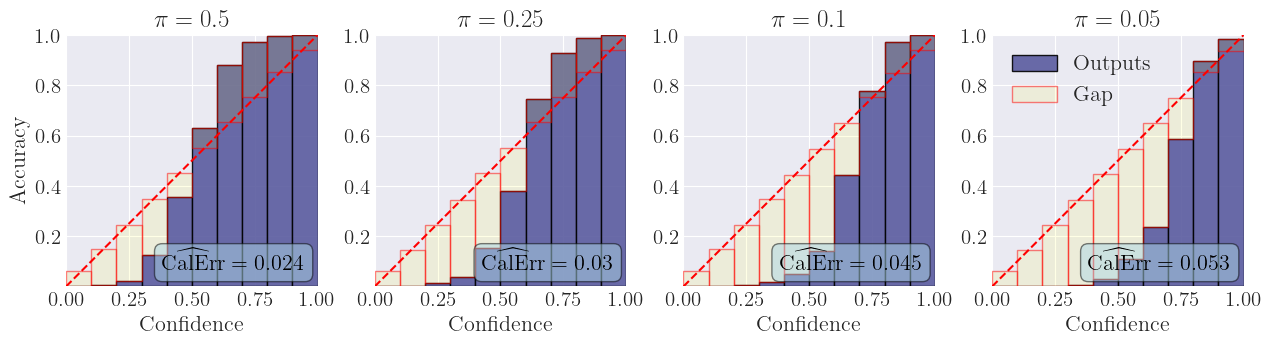

In [9]:
reliability_plots_sim(pi_list=[0.5, 0.25, 0.1, 0.05], n=1000, d=100, mu=2, save=True)

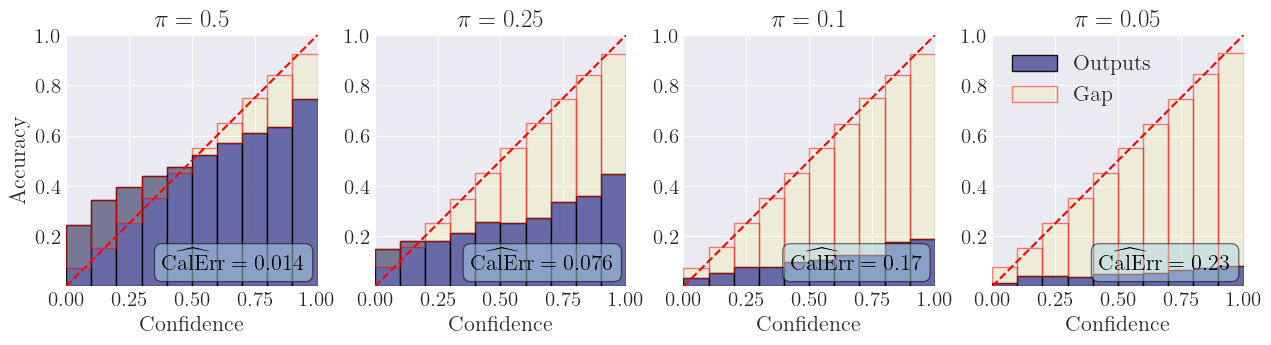

In [10]:
reliability_plots_sim(pi_list=[0.5, 0.25, 0.1, 0.05], n=1000, d=500, mu=0.5, save=True)

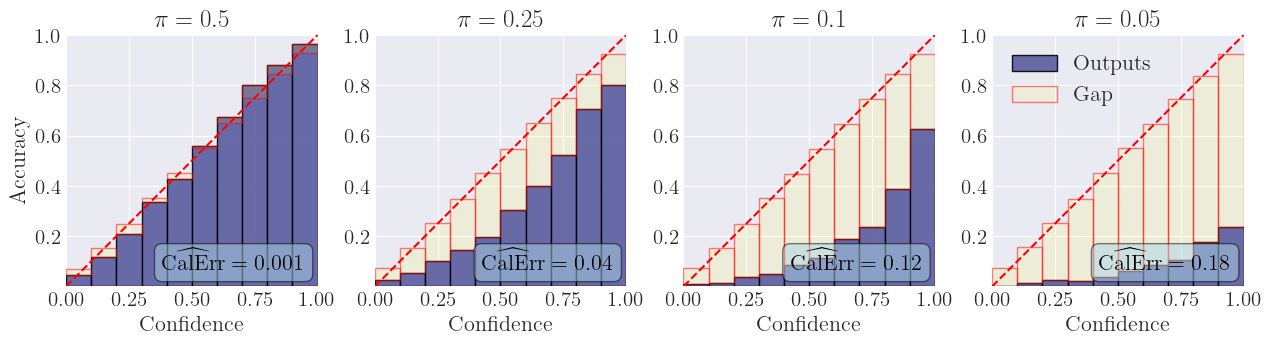

In [11]:
reliability_plots_sim(pi_list=[0.5, 0.25, 0.1, 0.05], n=1000, d=500, mu=1, save=True)

## Real Data

In [12]:
import os
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def logisticReg(X, y, tol=1e-8, class_weight=None, solver='lbfgs', max_iter=int(1e+6), standard=False):
    clf = LogisticRegression(penalty=None, tol=tol, fit_intercept=True, class_weight=class_weight,
                             solver=solver, max_iter=max_iter)
    clf.fit(X, y)
    beta = clf.coef_[0]
    beta0 = clf.intercept_[0]
    if standard:
        beta_norm = np.linalg.norm(beta)
        beta, beta0 = beta/beta_norm, beta0/beta_norm
    return [clf, beta, beta0]

# Binary classification
# Minority: y = 1, Majority: y = 0
def sim_imb_data2(data, pai=None):
    X, y = data
    if pai is None:
        return [X, y]
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]
    [n, n0, n1] = [y.shape[0], idx_0.shape[0], idx_1.shape[0]]
    if pai < n1/n:
        samp_idx = np.sort(np.random.choice(idx_1, size=int(n0*pai/(1-pai)), replace=False))
        index = np.concatenate([idx_0, samp_idx])
    else:
        samp_idx = np.sort(np.random.choice(idx_0, size=int(n1*(1-pai)/pai), replace=False))
        index = np.concatenate([samp_idx, idx_1])
    return [X[index, :], y[index]]

In [13]:
def reliability_plots_real(pi_list, X, y, sub_class, solver="LR", standard=False, seed=2024, fig_size=(12.6, 3.3),
                           num_bins=10, save=False, save_dir = ''):
    X_sub = X[np.isin(y, sub_class), :]
    y_sub = y[np.isin(y, sub_class)]
    # re-level the labels as 0, 1, 2, ...
    for i in range(len(sub_class)):
        y_sub[y_sub == sub_class[i]] = i
        print(f"Class {sub_class[i]} is assigned as class {i}")
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    with plt.style.context('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle'):
        fig, ax = plt.subplots(nrows=1, ncols=len(pi_list), figsize=fig_size, dpi=100, constrained_layout=True)
        np.random.seed(seed)
        for i, pi in enumerate(pi_list):
            X_imb, y_imb = sim_imb_data2([X_sub, y_sub], pai=pi)
            print("Imbalanced training Set:", dict(Counter(y_imb)))
            print("pi =", f"{dict(Counter(y_imb))[1]/np.shape(y_imb)[0]:.3f}")
            print("n =", f"{y_imb.shape[0]}")
            X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb, test_size=0.5, stratify=y_imb)
            if solver=="LR":
                md, beta, beta0 = logisticReg(X_train, y_train, class_weight=None, standard=standard)
            else:
                print('SVM')
                md, beta, beta0, _ = SVM(X_train, y_train, C=1)
                # Check linear separability
                if np.mean(md.predict(X_train) == y_train) < 1:
                    print(f'Training data is not separable for pi = {pi:.3f}.')
            accuracies, confidences, bin_centers, ece = get_calibration_stat(predictions=sigmoid(X_test @ beta + beta0),
                                                                             true_labels=y_test)
            ax[i].bar(bin_centers, accuracies, width=1/num_bins, color='#5A5B9F', alpha=0.9,
                      edgecolor='black', label='Outputs')
            ax[i].bar(bin_centers, confidences - accuracies, width=1/num_bins, color=(1, 1, 0, 0.1),
                      label='Gap', edgecolor=(1, 0, 0, 0.5), bottom=accuracies)
            ax[i].plot([0, 1], [0, 1], '--', color='red')
            ax[i].set_xlim(0, 1)
            ax[i].set_ylim(0, 1)
            ax[i].set_xlabel('Confidence', fontsize=16)
            if i == 0:
                ax[i].set_ylabel('Accuracy', fontsize=16)
            yticks = ax[i].get_yticks()
            ax[i].set_yticks([tick for tick in yticks if tick != 0])
            ax[i].tick_params(axis='x', labelsize=15)
            ax[i].tick_params(axis='y', labelsize=15)
            ax[i].set_title(rf'$\pi = {pi}$', fontsize=18)
            if i == len(pi_list) - 1:
                ax[i].legend(fontsize=16)
            ax[i].text(0.95, 0.05, rf"$\widehat{{\mathrm{{CalErr}}}}={ece:.2g}$", ha="right", va="bottom", fontsize=16,
                       color="black", bbox=dict(facecolor="lightblue", alpha=0.5, boxstyle="round,pad=0.35"))
            ax[i].set_aspect('equal')
    if save:
        plt.savefig(save_dir + f'{sub_class}.pdf')
        plt.show()
    else:
        plt.show()
    return None

### IMDb

In [14]:
DATA_DIR = "../data"
X = np.load(os.path.join(DATA_DIR, "IMDb_BERT_base_CLS_embedding_test.npy"))
y = np.load(os.path.join(DATA_DIR, "IMDb_BERT_base_CLS_labels_test.npy"))

Class 0 is assigned as class 0
Class 1 is assigned as class 1
Imbalanced training Set: {0: 12500, 1: 12500}
pi = 0.500
n = 25000
Imbalanced training Set: {0: 12500, 1: 4166}
pi = 0.250
n = 16666
Imbalanced training Set: {0: 12500, 1: 1388}
pi = 0.100
n = 13888
Imbalanced training Set: {0: 12500, 1: 657}
pi = 0.050
n = 13157


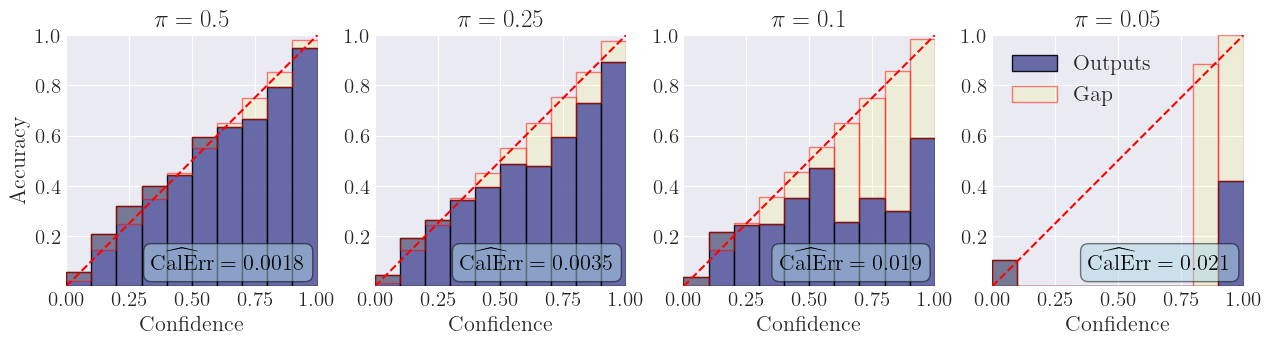

In [15]:
reliability_plots_real(pi_list=[0.5, 0.25, 0.1, 0.05], X=X, y=y, sub_class=[0, 1],
                       save_dir='IMDb(BERT110M)', save=True)